## Imports

In [9]:
import pandas as pd
import re
import timeit
import numpy as np
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
import sklearn.metrics as sm
from sklearn.ensemble import IsolationForest
import plotly.express as px
import numpy as np
import warnings
import datetime
import xgboost as xgb
import math
import joblib
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

from sktime.forecasting.compose import make_reduction, TransformedTargetForecaster
from sktime.forecasting.model_selection import ExpandingWindowSplitter, ForecastingGridSearchCV
import lightgbm as lgb

#Imports TFG Original
from prettytable import PrettyTable
from os import listdir
from os.path import isfile, join
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import accuracy_score , mean_squared_error
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from yellowbrick.model_selection import FeatureImportances
from sklearn.linear_model import LinearRegression



ModuleNotFoundError: No module named 'sktime'

## Funció Alineament de Dades

In [2]:
def alignSeries(serie, lag):
    minutesRow = 30
    posToMove = int(lag / minutesRow)  
    outputSerie = serie['data'].to_numpy()
    size = len(outputSerie)
    outputSerie = np.pad(outputSerie, (posToMove,0), 'constant', constant_values=(0))
    outputSerie = outputSerie[:size]
    return outputSerie

## Carregar Dades

In [3]:
def prepareDFMod(df, col):
    output = df[[col]]
    output.rename(columns={col:'data'}, inplace=True)
    return output
    

In [4]:
# Carregar dades pluja
def loadDataPrecipitacions():
    precipitacions = pd.read_excel("finalsDF/DF_SMC.xlsx", index_col=0)
    return precipitacions

In [5]:
# Carregar dades Alt Ter
def loadDataTer(nom, Ter):
    
    altTer = prepareDFMod(Ter, nom)
    
    return altTer

In [6]:
#Carregar dades precipitacions Alt Ter:
def loadDataPrecipitacions(nom, precipitacions):
    
    #Carregar dades
    precipitacions = prepareDFMod(precipitacions, nom)
    
    #Moving Average
    precipitacions['data'] = precipitacions['data'].rolling(window=5).mean()
    precipitacions['data'] = precipitacions['data'].rolling(window=5).mean()
    
    return precipitacions

In [ ]:
altTer = pd.read_excel("Dataframes/df_imputedAltTerKNN.xlsx", index_col=0)
baixTer = pd.read_excel("Dataframes/df_imputedBaixTerKNN.xlsx", index_col=0)
precipitacions = pd.read_csv("finalsDF/DF_SMC.csv", index_col=0)

# Alineament del DataFrame amb Referencia (Alt Ter)

In [14]:
massies = loadDataTer('L08116-72-00002', baixTer)

# Alineament del DataFrame amb Referencia (Baix Ter)

In [21]:
colomers = loadDataTer('L17055-72-00002', baixTer)

# Models Alt Ter

# LightGBM (Alt Ter)

In [4]:
#Carregar del csv
Df_AltX = pd.read_csv('dfAltX.csv')
Df_Alty = pd.read_csv('dfAltY.csv')

In [5]:
Df_AltX.set_index('datetime', drop=True, inplace=True)
Df_Alty.set_index('DATA', drop=True, inplace=True)

Iteració:  1
CPU times: total: 797 ms
Wall time: 33.1 s


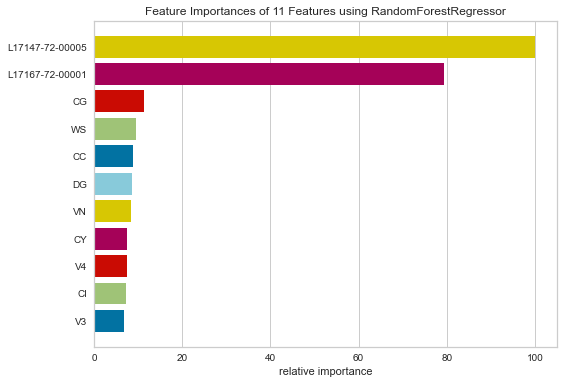

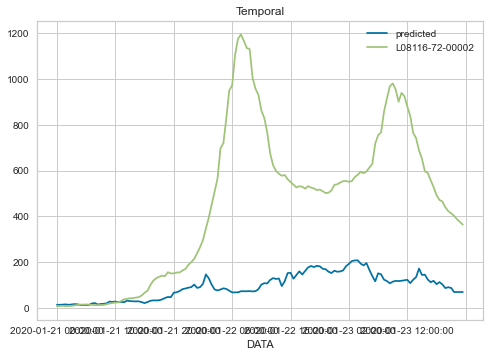

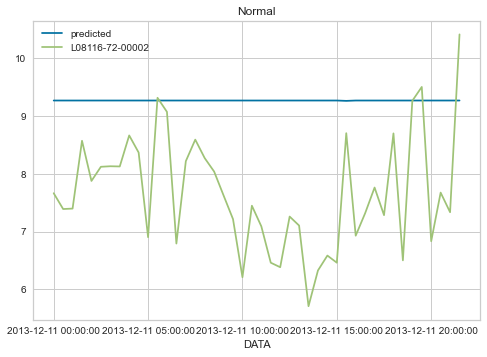

Iteració:  2
CPU times: total: 2.03 s
Wall time: 1min 12s


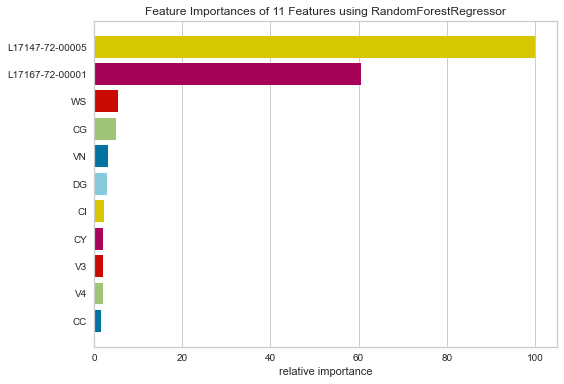

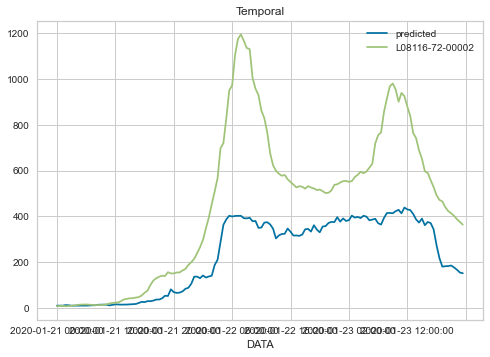

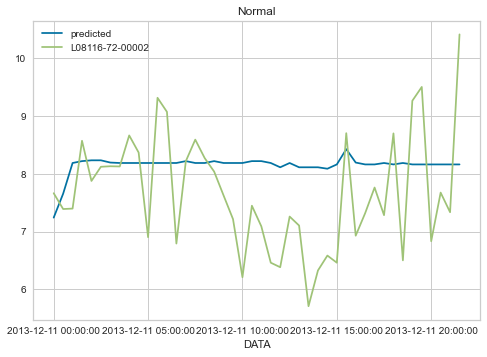

Iteració:  3
CPU times: total: 25.8 s
Wall time: 2min 18s


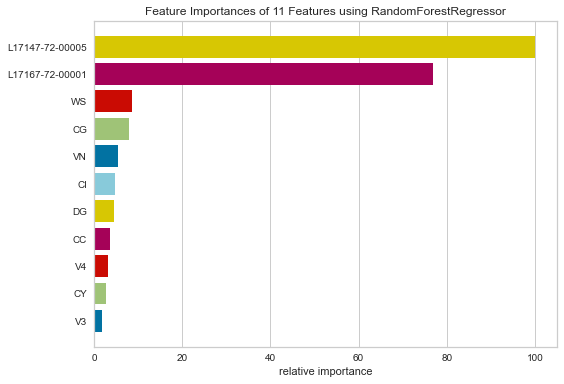

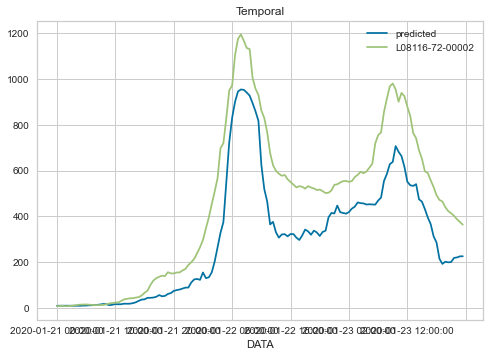

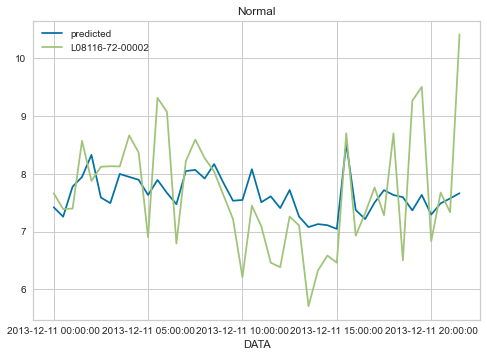

Iteració:  4
CPU times: total: 4.67 s
Wall time: 2min 49s


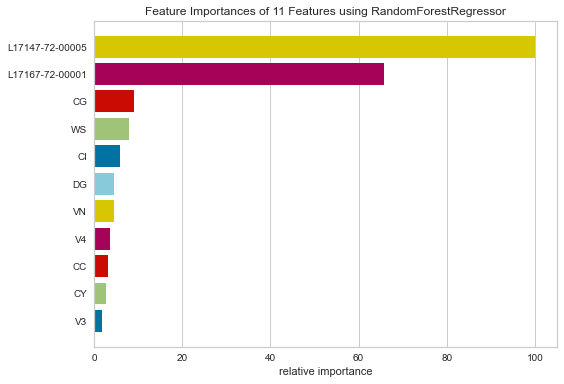

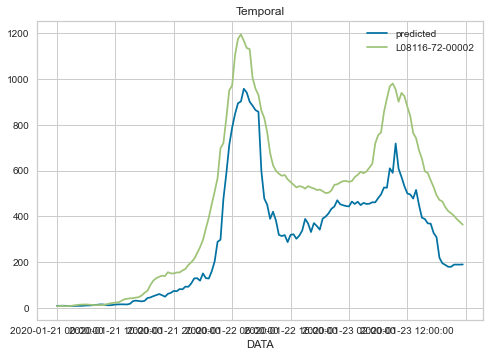

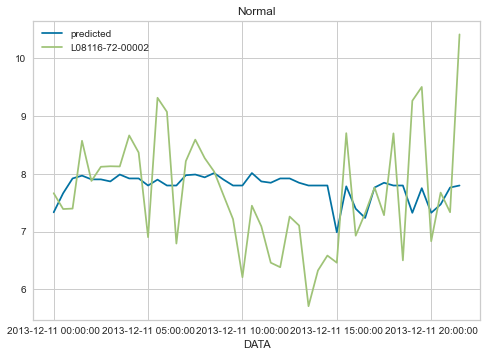

Iteració:  5
CPU times: total: 5.91 s
Wall time: 3min 47s


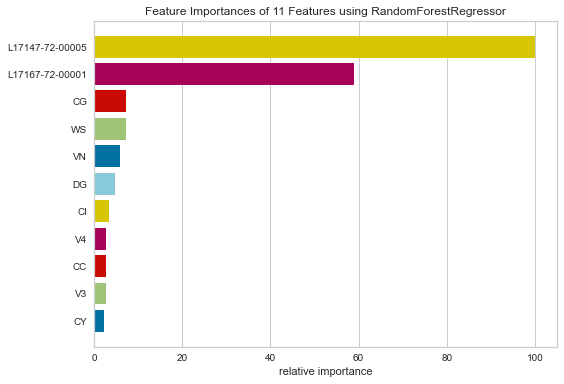

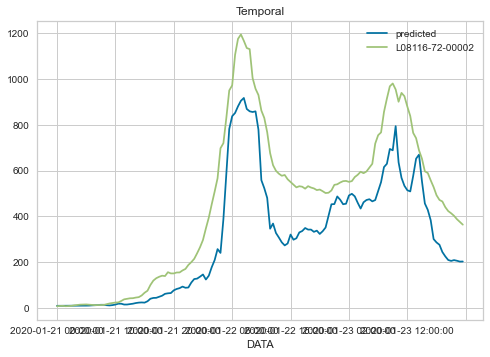

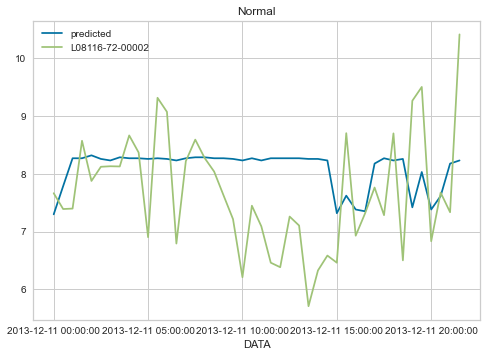

Time:  0:10:49.567289


In [25]:
start = timeit.default_timer()

tscv = TimeSeriesSplit(n_splits=5)
param_search = { 
    'n_estimators': [50,100, 200], # Nombre de arbres
    'max_features': [1, 'sqrt', 'log2'], # Maxim features
    'max_depth' : [8,10,25,None] # Profunditat dels arbres
}

iteracio = 0
for train_index, test_index in tscv.split(Df_AltX):
    iteracio += 1
    Df_AltX_train, Df_AltX_test = Df_AltX.values[train_index], Df_AltX.values[test_index]
    Df_Alty_train, Df_Alty_test = Df_Alty.values.ravel()[train_index], Df_Alty.values.ravel()[test_index]

    model = RandomForestRegressor()
    tscv = TimeSeriesSplit()
    gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, n_jobs=-1)
    print("Iteració: ", iteracio)
    %time gsearchfited = gsearch.fit(Df_AltX_train, Df_Alty_train)
        
    bestParams = gsearchfited.best_params_
    score = gsearchfited.score(Df_AltX_test, Df_Alty_test)
    FeatureImportance = gsearchfited.best_estimator_.feature_importances_
    
    predicty = gsearchfited.best_estimator_.predict(Df_AltX_test)
    rmseScore = mean_squared_error(Df_Alty_test, predicty, squared=False)
    
    nameh = Df_AltX.columns[0]
    hores = "1 day"
    
    new_row = {'Method':'Random Forest','Best_Params':bestParams, 'Features':Df_AltX.columns, 'Feature_Importance':FeatureImportance, 'Score':score,'RMSE_Score':rmseScore,"Prediccio_Hores":hores}
    df_results_altTer = df_results_altTer.append(new_row, ignore_index=True)
    
    joblib.dump(gsearchfited.best_estimator_, 'resultsDf/pickle/partAlta/RandomForest_'+str(df_results_altTer.index[-1])+'.pkl', compress = 1)

    viz = FeatureImportances(gsearchfited.best_estimator_)
    viz.fit(Df_AltX, Df_Alty)
    viz.show()
    
    plotYtest = Df_Alty["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotYtest2 = Df_Alty["2013-12-10 5:00:00":"2013-12-11 21:30:00"]
    
    plotXtestp = Df_AltX["2020-01-20 5:00:00":"2020-01-23 21:30:00"]
    plotXtest2p = Df_AltX["2013-12-10 5:00:00":"2013-12-11 21:30:00"]
    
    plotXtestr = gsearchfited.best_estimator_.predict(plotXtestp.values)
    plotXtest2r = gsearchfited.best_estimator_.predict(plotXtest2p.values)
    
    plotYtest.insert(0, 'predicted', plotXtestr, allow_duplicates=True)
    plotYtest2.insert(0, 'predicted', plotXtest2r, allow_duplicates=True)

    plotYtest.plot(title="Temporal")
    plotYtest2.plot(title="Normal")
    plt.show()

    
stop = timeit.default_timer()
print("Time: ", str(datetime.timedelta(seconds=(stop-start))))

In [26]:
df_results_altTer

,Method,Best_Params,Features,Feature_Importance,Score,RMSE_Score,Prediccio_Hores
0,Random Forest,"{'max_depth': 10, 'max_features': 1, 'n_estima...","Index(['L17147-72-00005', 'L17167-72-00001', '...","[0.3919043910490974, 0.31109527848182644, 0.03...",0.572664,14.247644,1 day
1,Random Forest,"{'max_depth': 8, 'max_features': 'log2', 'n_es...","Index(['L17147-72-00005', 'L17167-72-00001', '...","[0.5346705850391481, 0.32310016208476683, 0.01...",0.733682,16.236241,1 day
2,Random Forest,"{'max_depth': 25, 'max_features': 'sqrt', 'n_e...","Index(['L17147-72-00005', 'L17167-72-00001', '...","[0.4545360782642808, 0.34969794720824304, 0.02...",0.781344,6.942899,1 day
3,Random Forest,"{'max_depth': 10, 'max_features': 'sqrt', 'n_e...","Index(['L17147-72-00005', 'L17167-72-00001', '...","[0.47794412262904556, 0.3138619211111304, 0.02...",0.789117,14.728217,1 day
4,Random Forest,"{'max_depth': 10, 'max_features': 'sqrt', 'n_e...","Index(['L17147-72-00005', 'L17167-72-00001', '...","[0.5056481016528611, 0.29775496703205145, 0.02...",0.871446,14.647472,1 day
